$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\uv}{\mathbf{u}}
 \newcommand{\vv}{\mathbf{v}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\Um}{\mathbf{U}}
 \newcommand{\Vm}{\mathbf{V}} 
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
 \newcommand{\Lambdav}{\boldsymbol\Lambda}
$

# House Price Predictor


### ITCS 5156 Project

<br/>

NAME: Jose Salas-Ayala

</b> </font>

Step 1: Data Cleaning
The data that will be used is the same as the following reference research paper: T. D. Phan, "Housing Price Prediction Using Machine Learning Algorithms: The Case of Melbourne City, Australia," 2018 International Conference on Machine Learning and Data Engineering (iCMLDE), Sydney, NSW, Australia, 2018, pp. 35-42, doi: 10.1109/iCMLDE.2018.00017.


In [1]:
#import the neccassry libraries 
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import r2_score



The model selected will be a simple linear regression. This is because this model tends to work best as a basis to compare the accuracy of other models. It may not be able to capture the true curve for the best predictions but it will consistently give good predictions.

In [2]:
# Import the data

df = pd.read_csv('Melbourne_housing_FULL.csv')

#check the first 5 entries
df.head(5)
#df.shape

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,68 Studley St,2,h,NaN,SS,Jellis,3/09/2016,2.5,3067.0,...,1.0,1.0,126.0,NaN,NaN,Yarra City Council,-37.8014,144.9958,Northern Metropolitan,4019.0
1,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0
3,Abbotsford,18/659 Victoria St,3,u,NaN,VB,Rounds,4/02/2016,2.5,3067.0,...,2.0,1.0,0.0,NaN,NaN,Yarra City Council,-37.8114,145.0116,Northern Metropolitan,4019.0
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0


Data Cleaning: Recreating from the paper, where columns with %55 missing data are removed and rows with missing "Price" values are removed

In [21]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# estimator = LinearRegression()
# selector = SequentialFeatureSelector(estimator, 
#                                       scoring='neg_mean_squared_error', 
#                                       verbose=2, 
#                                       k_features='best', 
#                                       forward=False, 
#                                       n_jobs=-1)

# selected_features = X_train.columns[list(selector.k_feature_idx_)]
target = 'Price'
features = df.columns.drop(target)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=0)

# Define the estimator to use in the stepwise algorithm
estimator = LinearRegression()

# Define the stepwise selector, using the backward elimination method and the AIC criterion
selector = SequentialFeatureSelector(estimator, 
                                      
                                      scoring='neg_mean_squared_error', 
                                      verbose=2, 
                                      k_features='best', 
                                      forward=False, 
                                      n_jobs=-1)

# Fit the selector to the training data
selector.fit(X_train, y_train)

# Get the selected features and the final model
selected_features = X_train.columns[list(selector.k_feature_idx_)]



# Print the selected features and the model performance
print('Selected Features:', selected_features)


ValueError: 'mean_squared_error' is not a valid scoring value. Use sorted(sklearn.metrics.SCORERS.keys()) to get valid options.

In [4]:
missing_percentage = df.isna().mean()
#columns_to_drop = missing_percentage[missing_percentage > 0.55].index
df_housing = df.drop(columns=['Suburb','Address','Method','SellerG','Date','Postcode','Bedroom2','CouncilArea','Regionname','BuildingArea','YearBuilt'])
df_housing= df_housing.dropna(subset=['Price'])
df_housing= df_housing.dropna(subset=['Lattitude']) #in the paper they used googlemaps API to fill in the missing values but I didn't want to buy a key so I just dropped it instead.
df_housing = df_housing.dropna(thresh=6)
#matching the data in the reference paper leaves us with 11 variables



#imputations

grouped_df = df.groupby(['Type'])['Landsize'].median().reset_index()

# Function to impute missing values based on median values group by house types and suburbs
def impute_landsize(row):
    if pd.isnull(row['Landsize']):
        median_val = grouped_df.loc[(grouped_df['Type']==row['Type']) , 'Landsize'].values
        if len(median_val) > 0:
            return median_val[0]
        else:
            return row['Landsize']
    else:
        return row['Landsize']

df_housing['Landsize'] = df.apply(impute_landsize,axis=1)

#change NAN to 0 for bathrooms and carports
df_housing['Bathroom'] = df_housing['Bathroom'].fillna(0)
df_housing['Car'] = df_housing['Car'].fillna(0)

df_housing.head(5)
df_housing.shape
df_housing.describe()

,Rooms,Price,Distance,Bathroom,Car,Landsize,Lattitude,Longtitude,Propertycount
count,20993.000000,2.099300e+04,20993.000000,20993.000000,20993.000000,20993.000000,20993.000000,20993.000000,20993.000000
mean,3.059163,1.089746e+06,11.359020,1.575001,1.666889,571.868147,-37.806963,144.996711,7516.751489
std,0.949881,6.530283e+05,6.891418,0.715417,1.020688,3478.854327,0.091619,0.120680,4411.397778
min,1.000000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.570000e+05,6.400000,1.000000,1.000000,216.000000,-37.860900,144.925300,4380.000000
50%,3.000000,9.100000e+05,10.400000,1.000000,2.000000,541.000000,-37.800460,145.003200,6567.000000
75%,4.000000,1.335000e+06,14.200000,2.000000,2.000000,645.000000,-37.748970,145.068770,10331.000000
max,16.000000,1.120000e+07,48.100000,9.000000,18.000000,433014.000000,-37.397800,145.526350,21650.000000


After Datacleaning its time to use feature selection.
The research paper uses the following 11 variables to build its model.
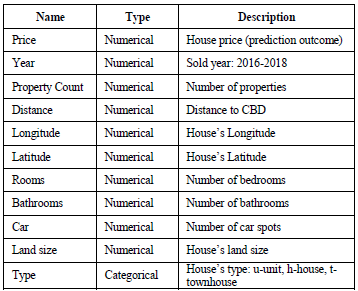

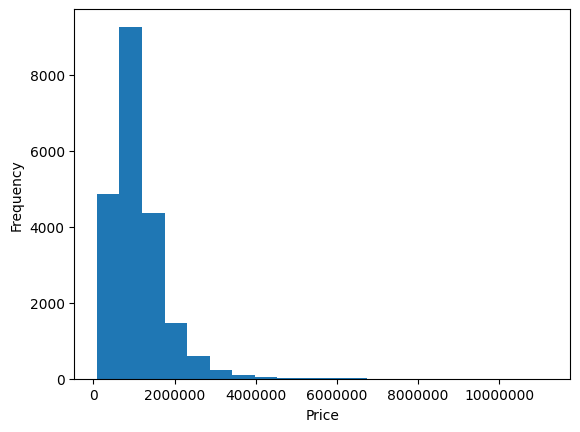

In [5]:
#Histogram of price
plt.hist(df_housing['Price'],bins=20)
plt.ticklabel_format(style='plain', axis='x')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

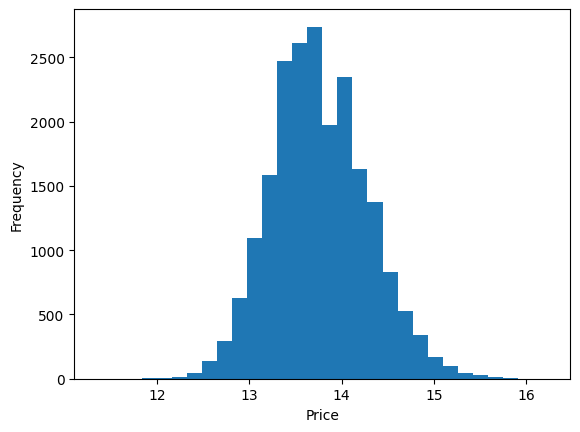

In [6]:
log_price = np.log(df_housing['Price'])

plt.hist(log_price, bins= 30)

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

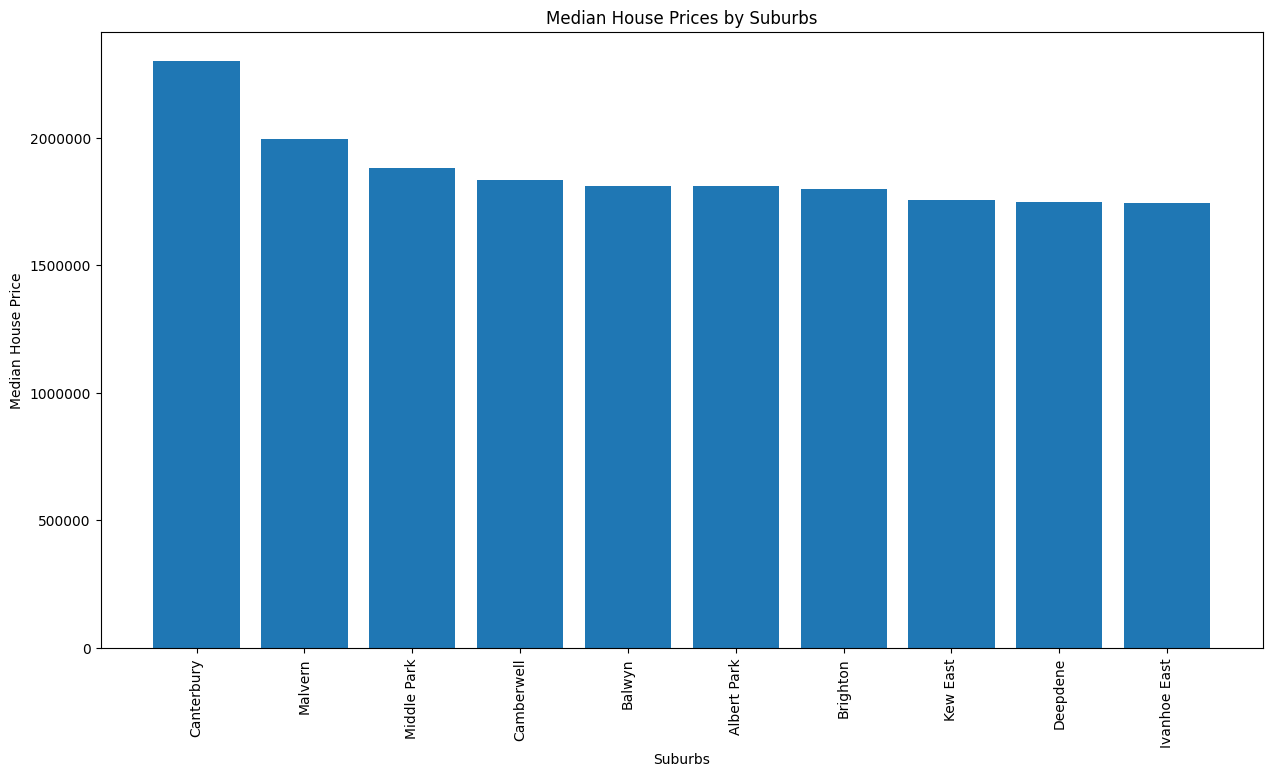

In [7]:
# create a dataframe with median house prices by suburbs
df_median_prices = df.groupby('Suburb')['Price'].median().reset_index().sort_values('Price', ascending=False)
most_expensive = df_median_prices[:10]

# plot a bar chart of the median house prices by suburbs
plt.figure(figsize=(15,8))
plt.bar(most_expensive['Suburb'], most_expensive['Price'])
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Suburbs')
plt.ylabel('Median House Price')
plt.title('Median House Prices by Suburbs')
plt.show()

The paper implements several different regression models to find useful ones such as Stepwise, Linear Rgresssion, Polynomial Regression, Regression Tree, Neural Network, SVM

In [8]:
df_housing = pd.get_dummies(df_housing, columns=['Type'])

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA

scaler = StandardScaler()
df_housing[['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize']] = scaler.fit_transform(df_housing[['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize']])

X = df_housing.drop('Price', axis=1)
target=df_housing['Price']

#split data
X_train, X_test, t_train, t_test = train_test_split(X,target,test_size=0.2)

#starting off with linear regression which is used as the baseline
linear_reg = LinearRegression(normalize=True)

linear_reg.fit(X_train,t_train)

t_pred =linear_reg.predict(X_test)

mse = mean_squared_error(t_test,t_pred)
training_score=linear_reg.score(X_train,t_train)
test_score = linear_reg.score(X_test,t_test)
print(f"Train score: {training_score}")
print(f"Test score: {test_score}")
y_pred = linear_reg.predict(X_test)
y = linear_reg.predict(X_test)
r2 = r2_score(t_test, y_pred)
print(f"MSE: {mse}")


Train score: 0.5219997583404989
Test score: 0.4905631816976269
MSE: 230404098759.94214


C:\Users\emman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Data Reduction and Transformation

In [10]:
predictors = X_train.columns
print(predictors)

coef = pd.Series(linear_reg.coef_,predictors).sort_values()
print(coef)

Index(['Rooms', 'Distance', 'Bathroom', 'Car', 'Landsize', 'Lattitude',
       'Longtitude', 'Propertycount', 'Type_h', 'Type_t', 'Type_u'],
      dtype='object')
Lattitude       -1.636183e+06
Distance        -3.102679e+05
Propertycount   -7.925497e-01
Landsize         2.053170e+04
Car              3.621980e+04
Bathroom         1.454440e+05
Rooms            1.742268e+05
Longtitude       8.832189e+05
Type_u           1.738499e+18
Type_t           1.738499e+18
Type_h           1.738499e+18
dtype: float64


In [11]:
y_pred = linear_reg.predict(X_test)

df_pred_actual=pd.DataFrame({'predicted': y_pred, 'actual':t_test})
df_pred_actual.head(10)

,predicted,actual
32541,1559296.0,1150000.0
9667,536832.0,354000.0
4519,1524480.0,1425000.0
3022,593408.0,601000.0
33686,886784.0,728000.0
21834,374272.0,472000.0
33202,1573376.0,1040000.0
25761,1128192.0,1302000.0
18080,1165824.0,1857000.0
17162,1751808.0,1400000.0


Model evaluations

Testing_score:  0.4905631816976269


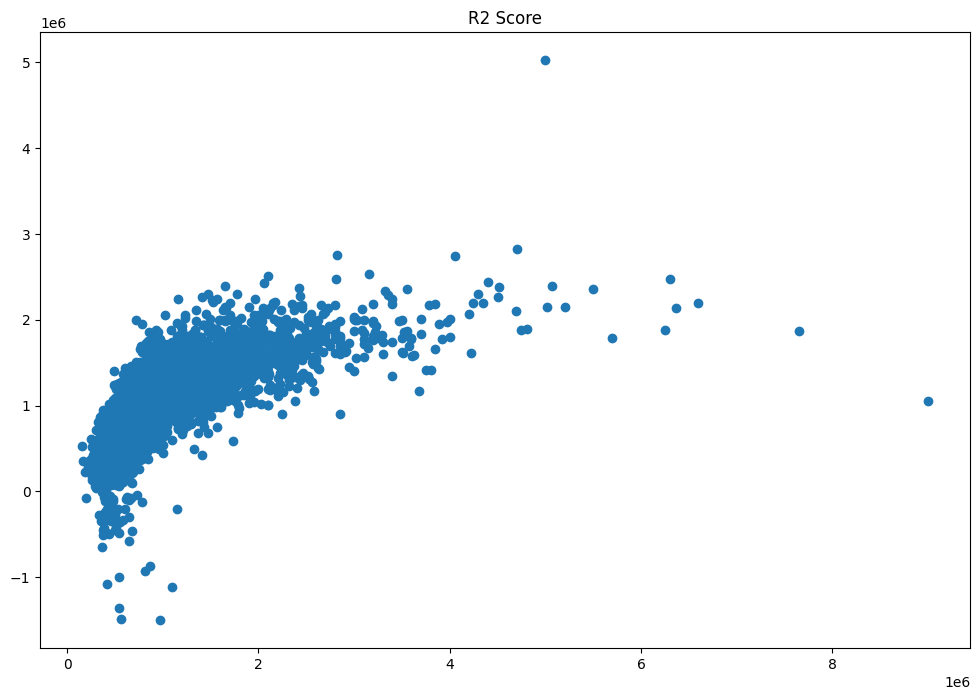

In [12]:
from sklearn.metrics import r2_score
print("Testing_score: ",r2_score(t_test,y_pred))

fig, ax =plt.subplots(figsize=(12,8))
plt.title("R2 Score")
plt.scatter(t_test,y_pred)
plt.show()

Using and evaluating other models
Poly Regression

In [13]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_reg = LinearRegression().fit(X_train_poly, t_train)


y_pred_poly = poly_reg.predict(X_test_poly)

mse_poly = mean_squared_error(t_test, y_pred)
r2_poly = r2_score(t_test, y_pred)
training_score_poly=poly_reg.score(X_train_poly,t_train)
test_score_poly = poly_reg.score(X_test_poly,t_test)
print(f"Train score: {training_score_poly}")
print(f"Test score: {test_score_poly}")
print(f"MSE: {mse_poly}")
print(f"R-squared score: {r2_poly}")

Train score: 0.6470529901893627
Test score: 0.6102466734123506
MSE: 230404098759.94214
R-squared score: 0.4905631816976269


Regression Tree


In [14]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, t_train)

t_pred = tree_reg.predict(X_test)

training_score_tree=tree_reg.score(X_train,t_train)
test_score_tree = tree_reg.score(X_test,t_test)

mse_tree = mean_squared_error(t_test, t_pred)
r2_tree = r2_score(t_test, t_pred)

print(f"Train score: {training_score_tree}")
print(f"Test score: {test_score_tree}")
print(f"MSE: {mse_tree}")
print(f"R-squared score: {r2_tree}")

Train score: 0.9998762760505036
Test score: 0.628084173590722
MSE: 168207180399.60638
R-squared score: 0.628084173590722


Neural Network

In [15]:
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
X_train_neural = scaler.fit_transform(X_train)
X_test_neural = scaler.transform(X_test)

neural_model = MLPRegressor(hidden_layer_sizes=(50,50,50), max_iter=1000)

neural_model.fit(X_train, t_train)
y_pred = neural_model.predict(X_test)


mse_nn = mean_squared_error(t_test, y_pred)
r2_nn = r2_score(t_test, y_pred)

training_score_neural=neural_model.score(X_train,t_train)
test_score_neural = neural_model.score(X_test,t_test)

print(f"Train score: {training_score_neural}")
print(f"Test score: {test_score_neural}")
print(f"MSE: {mse_nn}")
print(f"R-squared score: {r2_nn}")


Train score: 0.4828654452846657
Test score: 0.4677978800339685
MSE: 240700211299.064
R-squared score: 0.4677978800339685


SVM

In [16]:
from sklearn.svm import SVR
svm_reg = SVR(kernel='linear')
svm_reg.fit(X_train, t_train)

y_pred = svm_reg.predict(X_test)

mse_svm = mean_squared_error(t_test, y_pred)
r2_svm = r2_score(t_test, y_pred)

training_score_svm=svm_reg.score(X_train,t_train)
test_score_svm = svm_reg.score(X_test,t_test)

print(f"Train score: {training_score_svm}")
print(f"Test score: {test_score_svm}")
print(f"MSE: {mse_svm}")
print(f"R-squared score: {r2_svm}")

Train score: -0.05327021595517989
Test score: -0.05190911088793837
MSE: 475749223385.84033
R-squared score: -0.05190911088793837


In [17]:
# from sklearn.decomposition import PCA
# from sklearn.svm import SVC
# from sklearn.pipeline import make_pipeline

# pca = PCA(n_components=10) 
# svm_pca = SVC(kernel='linear', C=1.0)
# svm_pipe = make_pipeline(pca, svm_pca)
# svm_pipe.fit(X_train, t_train)

# score = svm_pipe.score(X_test, t_test)
# print(score)

Prediction Results:

In [18]:
scores = {
    'Linear Regression': [training_score, test_score, mse, r2],
    'Polynomial Regression': [training_score_poly, test_score_poly, mse_poly, r2_poly],
    'Regression Tree': [training_score_tree, test_score_tree, mse_tree, r2_tree],
    'Neural Network': [training_score_neural, test_score_neural, mse_nn, r2_nn],
    'Support Vector Machine': [training_score_svm, test_score_svm, mse_svm, r2_svm]
}
df_scores = pd.DataFrame(scores, index=['Train Score', 'Test Score', 'MSE', 'R-squared'])

print(df_scores.to_string(float_format="{:.5f}".format))


             Linear Regression  Polynomial Regression    Regression Tree     Neural Network  Support Vector Machine
Train Score            0.52200                0.64705            0.99988            0.48287                -0.05327
Test Score             0.49056                0.61025            0.62808            0.46780                -0.05191
MSE         230404098759.94214     230404098759.94214 168207180399.60638 240700211299.06400      475749223385.84033
R-squared              0.49056                0.49056            0.62808            0.46780                -0.05191


Conclusion:
It seems that the regression tree had the overall best performance of the models but it is far from perfect and not nearly as good as the ones obtain in the research paper. Perhaps there was a mistake made during the preprocessing phase or with the selection of features. In either case 